In [1]:
import os
if 'flearn' not in os.listdir():
    os.chdir('../')

from flearn.common.dataset import read_data

SyntaxError: invalid syntax (<ipython-input-1-9137e32ff9f3>, line 3)

In [23]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [24]:
train_dir='data/vehicle/train/'
test_dir='data/vehicle/test/'

In [25]:
clients, groups, train_data, test_data = read_data(train_dir, test_dir, True)

# Distribution of target - Vehicle

In [26]:
count_label = []
for key, val in train_data.items():
    y = val['y']
    pos = (y == 1).sum().item()
    neg = len(y) - pos
    count_label.append(
    {
        'client': key,
        'pos': pos,
        'neg': neg
    })

In [27]:
df = pd.DataFrame(count_label)

In [ ]:
pos = 0
neg = 0
for i in count_label:
    pos += i['pos']
    neg += i['neg']

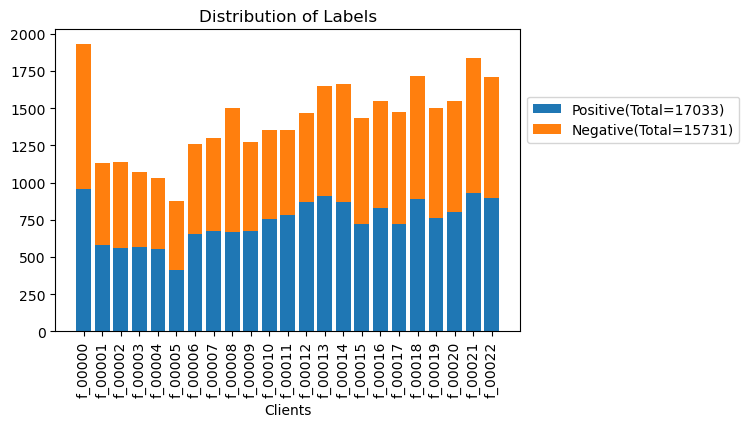

In [37]:
fig, ax = plt.subplots()
plt.xticks(df.index, df.client, rotation='vertical')
ax.bar(df.index, df.pos, label=f'Positive(Total={pos})')
ax.bar(df.index, df.neg, label=f'Negative(Total={neg})', bottom=df.pos)
ax.legend(bbox_to_anchor=(1.0, 0.8))
ax.set_title("Distribution of Labels")
ax.set_xlabel('Clients')
plt.savefig('labels.png')

In [34]:
neg

15731

# Fairness Violation

In [2]:
import os
if 'flearn' not in os.listdir():
    os.chdir('../')

from viz.utils import *
from main import run_vehicle

plt.rcParams['figure.dpi'] = 140

In [2]:
def get_fairness(df):
    fairness = []
    for r in df['round'].unique():
        res = df[(df['round']==r) & (df['c_name'] != 'global')]
        min_max = res.test_acc.max() - res.test_acc.min()
        var = res.test_acc.var()*1e4
        gi = gini(res.test_acc.tolist())
        acc = df[df['c_name'] == 'global']['test_acc'].tolist()[-1]
        fairness.append({
            'round': r,
            'min_max': min_max,
            'var':var,
            'gini': gi,
            'acc': acc
        })
    return fairness

In [3]:
def train_model(train_dir='data/vehicle/train/',
                test_dir='data/vehicle/test/',
                method_name='DL_FedAvgServer',
                s=0.5,
                q=5.0
               ):
    configs={
        # Model configs
        'layer_sizes': [100,1], 'act_funcs': ['none'],
        'dataset_name': 'vehicle',
        'method_name': method_name,
        # Server configs
        'num_rounds': 20,
        'pct_client_per_round': 10.0/23.0,
        'num_epochs': 1,
        'batch_size': 64,
        'lr': 0.01,
        's': s,
        'q': q,
        'disable_tqdm':False
    }

    server, clients = run_vehicle(train_dir, test_dir, configs, report=False)
    # df = get_results_from_server(server)
    return server, clients

In [4]:
from sklearn.model_selection import ParameterGrid

grid = [
    {
        "method_name": ['QFedAvgServer'],
        'q': [0, 1, 2, 3, 5, 10, 15, 50]
    },
    {
        "method_name": ['DL_FedAvgServer'],
        's': [0, 1, 2, 3, 5, 10, 15, 50]
    }
]

experiments = []

for params in list(ParameterGrid(grid)):
   
    server, clients = train_model(**params)
    df = get_results_from_server(server)
    fn = get_fairness(df)
    params.update(fn[-1])
    experiments.append(
        params
    )

  0%|          | 0/20 [00:00<?, ?it/s]/home/huypham/Projects/federate-learning/flearn/algo/server.py:364: RuntimeWarning: invalid value encountered in double_scalars
  clt.update_lambda(clt.get_lambda()/k)
100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


In [5]:
exp = pd.DataFrame(experiments)

In [6]:
exp

,method_name,q,round,min_max,var,gini,acc,s
0,QFedAvgServer,0.0,20,0.108738,6.992814,0.015720,0.929924,NaN
1,QFedAvgServer,1.0,20,0.092322,5.494686,0.013782,0.934041,NaN
2,QFedAvgServer,2.0,20,0.093138,6.066668,0.014618,0.933126,NaN
3,QFedAvgServer,3.0,20,0.110644,7.029575,0.015654,0.930290,NaN
4,QFedAvgServer,5.0,20,0.101593,6.323495,0.014851,0.932120,NaN
5,QFedAvgServer,10.0,20,0.100802,5.977930,0.014389,0.930199,NaN
6,QFedAvgServer,15.0,20,0.118515,7.324823,0.015736,0.930564,NaN
7,QFedAvgServer,50.0,20,0.106986,6.375410,0.014653,0.931571,NaN
8,DL_FedAvgServer,NaN,19,0.089847,5.564415,0.014105,0.931754,0.0
9,DL_FedAvgServer,NaN,19,0.099336,5.381384,0.013650,0.931388,1.0


<AxesSubplot:xlabel='q'>

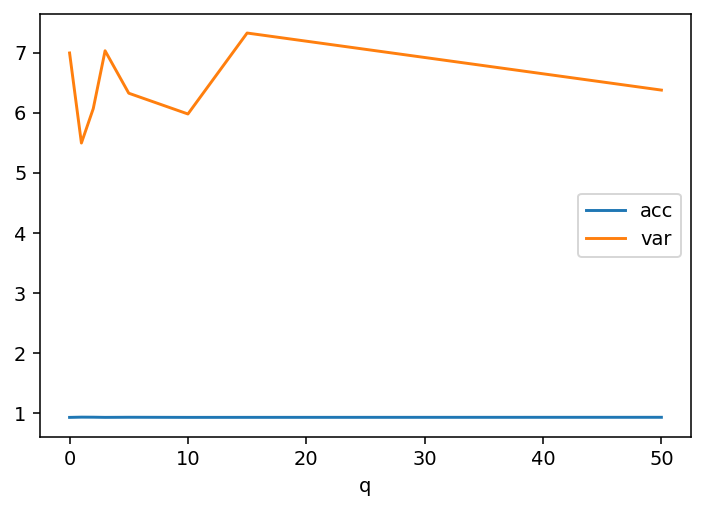

In [7]:
# QFed
df1 = exp[exp['method_name'] == 'QFedAvgServer'][['q', 'acc', 'var']]
df1.plot(x='q')

<AxesSubplot:xlabel='s'>

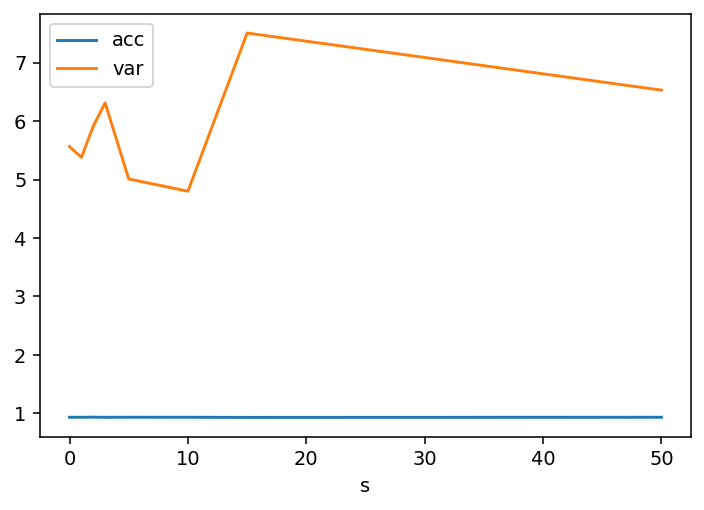

In [8]:
# DL_Fed
df2 = exp[exp['method_name'] == 'DL_FedAvgServer'][['s', 'acc', 'var']]
df2.plot(x='s')

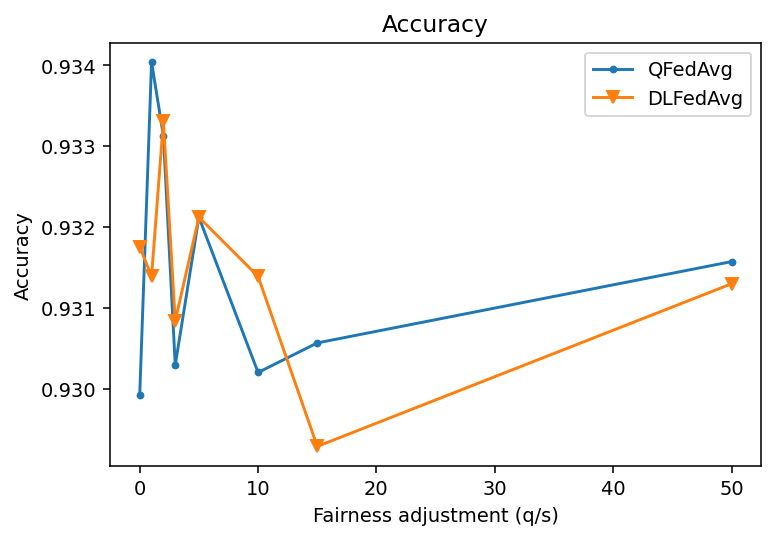

In [19]:
label = 'acc'

x = df1.q
y1 = df1[label]
y2 = df2[label]

plt.plot(x, y1, label = 'QFedAvg', marker=".")
plt.plot(x, y2, label = 'DLFedAvg', marker="v")
plt.xlabel('Fairness adjustment (q/s)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.savefig('Accuracy.png')

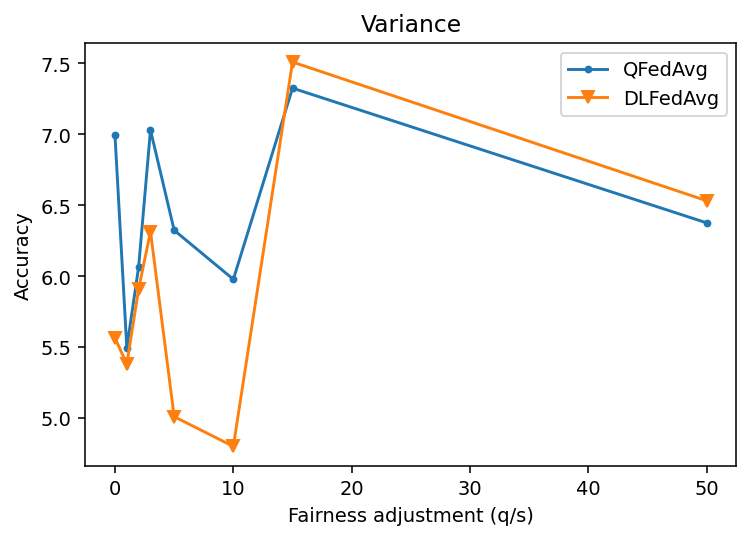

In [20]:
label = 'var'

x = df1.q
y1 = df1[label]
y2 = df2[label]

plt.plot(x, y1, label = 'QFedAvg', marker=".")
plt.plot(x, y2, label = 'DLFedAvg', marker="v")
plt.xlabel('Fairness adjustment (q/s)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Variance')
plt.savefig('var.png')

# Loss DLFedAvg

In [12]:
def train_model(train_dir='data/vehicle/train/',
                test_dir='data/vehicle/test/',
                method_name='DL_FedAvgServer',
                s=0.5,
                q=5.0
               ):
    configs={
        # Model configs
        'layer_sizes': [100,1], 'act_funcs': ['none'],
        'dataset_name': 'vehicle',
        'method_name': method_name,
        # Server configs
        'num_rounds': 20,
        'pct_client_per_round': 10.0/23.0,
        'num_epochs': 1,
        'batch_size': 64,
        'lr': 0.01,
        's': s,
        'q': q,
        'disable_tqdm':False
    }

    server, clients = run_vehicle(train_dir, test_dir, configs, report=False)
    # df = get_results_from_server(server)
    return server, clients

server, clients = train_model(method_name='DL_FedAvgServer', s=5)

100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


In [13]:
df = get_results_from_server(server)

In [14]:
c_name = ['f_00000', 'f_00022', 'f_00021', 'f_00020', 'f_00019',
       'f_00018', 'f_00016', 'f_00015', 'f_00014', 'f_00013', 'f_00012',
       'f_00017', 'f_00010', 'f_00009', 'f_00008', 'f_00007', 'f_00006',
       'f_00005', 'f_00004', 'f_00003', 'f_00002', 'f_00001', 'f_00011']

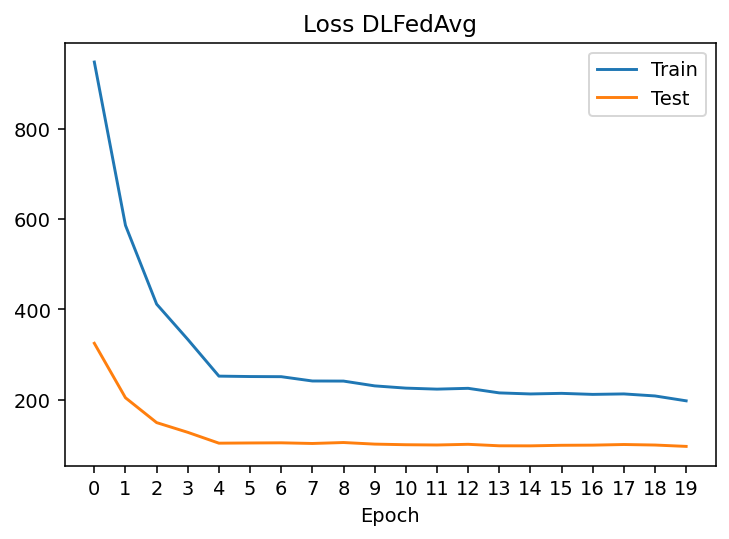

In [15]:
x = range(20)
train_loss = df.groupby('round')['train_loss'].mean()
test_loss = df.groupby('round')['test_loss'].mean()

plt.plot(x, train_loss, label='Train')
plt.plot(x, test_loss, label='Test')
plt.xticks(x)
plt.xlabel('Epoch')
plt.title('Loss DLFedAvg')
plt.legend()

plt.savefig('Loss_DLFedAvg.png')

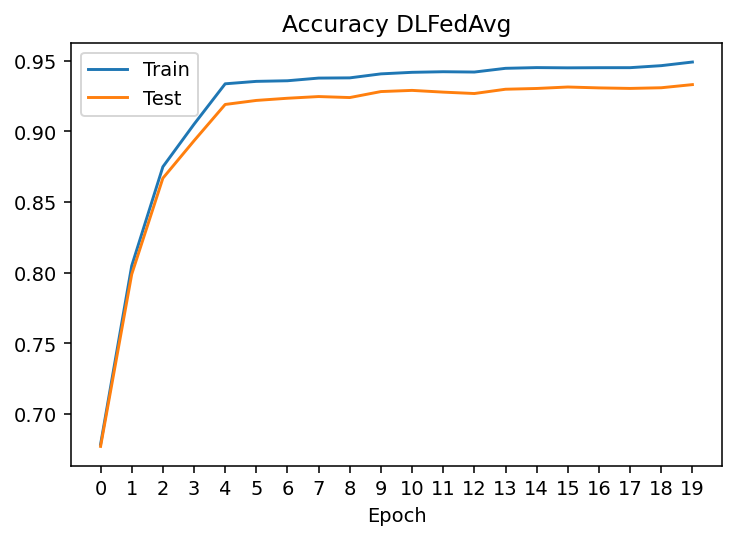

In [16]:
x = range(20)
train_loss = df.groupby('round')['train_acc'].mean()
test_loss = df.groupby('round')['test_acc'].mean()

plt.plot(x, train_loss, label='Train')
plt.plot(x, test_loss, label='Test')
plt.xticks(x)
plt.xlabel('Epoch')
plt.title('Accuracy DLFedAvg')
plt.legend()

plt.savefig('Acc_DLFedAvg.png')

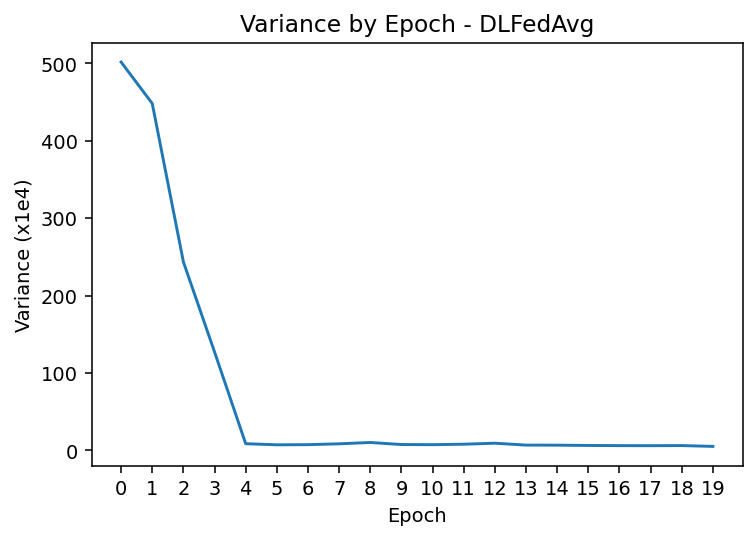

In [21]:
dl_acc_list = server.metrics.metrics['acc']

var_list = []
for acc in dl_acc_list:
    var_list.append(np.var(list(acc.values())) * 1e4)
plt.title("Variance by Epoch - DLFedAvg")
plt.xticks(range(20))
plt.xlabel('Epoch')
plt.ylabel('Variance (x1e4)')
plt.plot(var_list)
plt.savefig('var_by_epoch_dl.png')

# Loss QFedAvg

In [3]:
def train_model(train_dir='data/vehicle/train/',
                test_dir='data/vehicle/test/',
                method_name='QFedAvgServer',
                s=0.5,
                q=5.0
               ):
    configs={
        # Model configs
        'layer_sizes': [100,1], 'act_funcs': ['none'],
        'dataset_name': 'vehicle',
        'method_name': method_name,
        # Server configs
        'num_rounds': 20,
        'pct_client_per_round': 10.0/23.0,
        'num_epochs': 1,
        'batch_size': 64,
        'lr': 0.01,
        's': s,
        'q': q,
        'disable_tqdm':False
    }

    server, clients = run_vehicle(train_dir, test_dir, configs, report=False)
    # df = get_results_from_server(server)
    return server, clients

server, clients = train_model(method_name='QFedAvgServer', q=5)

100%|██████████| 20/20 [00:02<00:00,  6.90it/s]


In [4]:
df = get_results_from_server(server)

In [5]:
c_name = ['f_00000', 'f_00022', 'f_00021', 'f_00020', 'f_00019',
       'f_00018', 'f_00016', 'f_00015', 'f_00014', 'f_00013', 'f_00012',
       'f_00017', 'f_00010', 'f_00009', 'f_00008', 'f_00007', 'f_00006',
       'f_00005', 'f_00004', 'f_00003', 'f_00002', 'f_00001', 'f_00011']

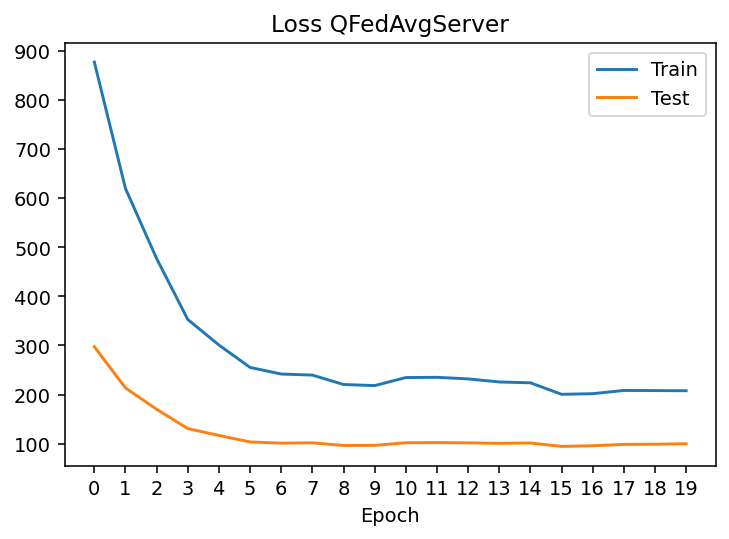

In [6]:
x = range(20)
train_loss = df.groupby('round')['train_loss'].mean()
test_loss = df.groupby('round')['test_loss'].mean()

plt.plot(x, train_loss, label='Train')
plt.plot(x, test_loss, label='Test')
plt.xticks(x)
plt.xlabel('Epoch')
plt.title('Loss QFedAvgServer')
plt.legend()

plt.savefig('Loss_QFedAvgServer.png')

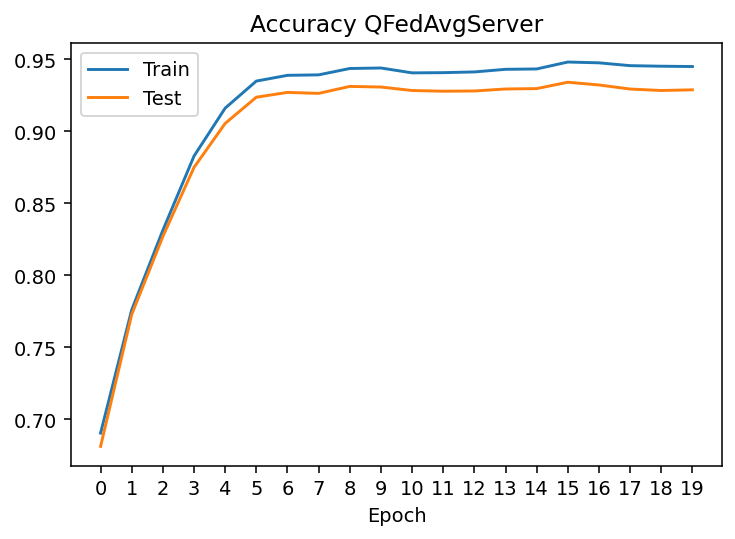

In [7]:
x = range(20)
train_loss = df.groupby('round')['train_acc'].mean()
test_loss = df.groupby('round')['test_acc'].mean()

plt.plot(x, train_loss, label='Train')
plt.plot(x, test_loss, label='Test')
plt.xticks(x)
plt.xlabel('Epoch')
plt.title('Accuracy QFedAvgServer')
plt.legend()

plt.savefig('Acc_QFedAvgServer.png')

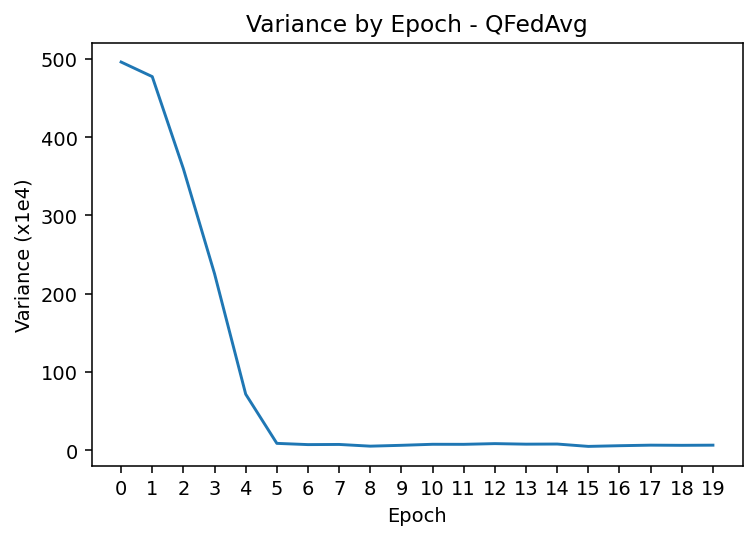

In [8]:
q_acc_list = server.metrics.metrics['acc']

var_list = []
for acc in q_acc_list:
    var_list.append(np.var(list(acc.values())) * 1e4)
plt.title("Variance by Epoch - QFedAvg")
plt.xticks(range(20))
plt.xlabel('Epoch')
plt.ylabel('Variance (x1e4)')
plt.plot(var_list)
plt.savefig('var_by_epoch_q.png')

# Explore Lambda in DLFedAvg

In [1]:
import os
if 'flearn' not in os.listdir():
    os.chdir('../')

from viz.utils import *
from main import run_vehicle

plt.rcParams['figure.dpi'] = 140

In [2]:
def train_model(train_dir='data/vehicle/train/',
                test_dir='data/vehicle/test/',
                method_name='QFedAvgServer',
                s=0.5,
                q=5.0
               ):
    configs={
        # Model configs
        'layer_sizes': [100,1], 'act_funcs': ['none'],
        'dataset_name': 'vehicle',
        'method_name': method_name,
        # Server configs
        'num_rounds': 20,
        'pct_client_per_round': 10.0/23.0,
        'num_epochs': 1,
        'batch_size': 64,
        'lr': 0.01,
        's': s,
        'q': q,
        'disable_tqdm':False
    }

    server, clients = run_vehicle(train_dir, test_dir, configs, report=False)
    # df = get_results_from_server(server)
    return server, clients

server, clients = train_model(method_name='DL_FedAvgServer', q=5)

100%|██████████| 20/20 [00:02<00:00,  7.05it/s]


In [3]:
df = get_results_from_server(server)

In [4]:
ld_hist = server.metrics.metrics['lambda']

In [5]:
c_name = ['f_00000', 'f_00022', 'f_00021', 'f_00020', 'f_00019',
       'f_00018', 'f_00016', 'f_00015', 'f_00014', 'f_00013', 'f_00012',
       'f_00017', 'f_00010', 'f_00009', 'f_00008', 'f_00007', 'f_00006',
       'f_00005', 'f_00004', 'f_00003', 'f_00002', 'f_00001', 'f_00011']

In [6]:
ld_hist[2]

{'f_00000': 0.0006159645406277417,
 'f_00001': 9.0050498527793e-05,
 'f_00002': 0.07714333312387293,
 'f_00003': 0.05716363908038946,
 'f_00004': 0.0,
 'f_00005': 0.0,
 'f_00006': 0.0,
 'f_00007': 0.04060870439818328,
 'f_00008': 1.3368350644128363e-07,
 'f_00009': 0.0005064107289735302,
 'f_00010': 0.03419246238250506,
 'f_00011': 0.2557293249251016,
 'f_00012': 0.0,
 'f_00013': 0.04477676781757624,
 'f_00014': 0.2076492201125051,
 'f_00015': 0.04642703208315943,
 'f_00016': 0.0,
 'f_00017': 1.1217517218229949e-06,
 'f_00018': 0.11291096052933935,
 'f_00019': 4.175510351646972e-05,
 'f_00020': 0.00046573715657843384,
 'f_00021': 0.12162773268307826,
 'f_00022': 4.9649400837015054e-05}

In [7]:
ld_means = []
for ld in ld_hist:
    ld_means.append(np.mean(list(ld.values())))

In [8]:
ld_means

[0.04347826086956521,
 0.043478260869565216,
 0.04347826086956521,
 0.043478260869565216,
 0.043478260869565216,
 0.04347826086956523,
 0.043478260869565216,
 0.043478260869565216,
 0.04347826086956523,
 0.04347826086956523,
 0.043478260869565216,
 0.04347826086956521,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.04347826086956521,
 0.043478260869565216,
 0.043478260869565216,
 0.04347826086956521]

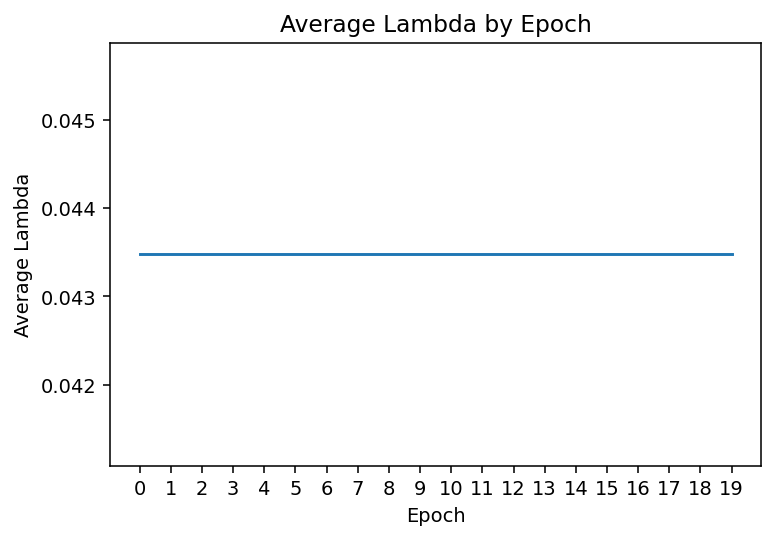

In [36]:
plt.title('Average Lambda by Epoch')
plt.xticks(range(20))
plt.plot(ld_means)
plt.xlabel('Epoch')
plt.ylabel('Average Lambda')
plt.savefig('Average_lambda.png')

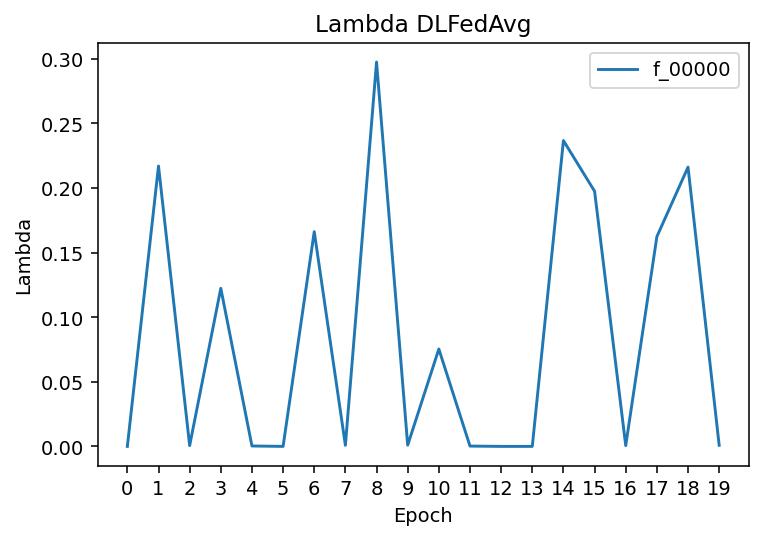

In [10]:
c_name = 'f_00000'
ld_list_00 = []
x = range(20)
for ld in ld_hist:
    ld_list_00.append(ld[c_name])
plt.title('Lambda DLFedAvg')
plt.xlabel('Epoch')
plt.ylabel('Lambda')
plt.xticks(x)
plt.plot(x, ld_list_00, label=c_name)
plt.legend()
plt.savefig(c_name+'_lambda.png')

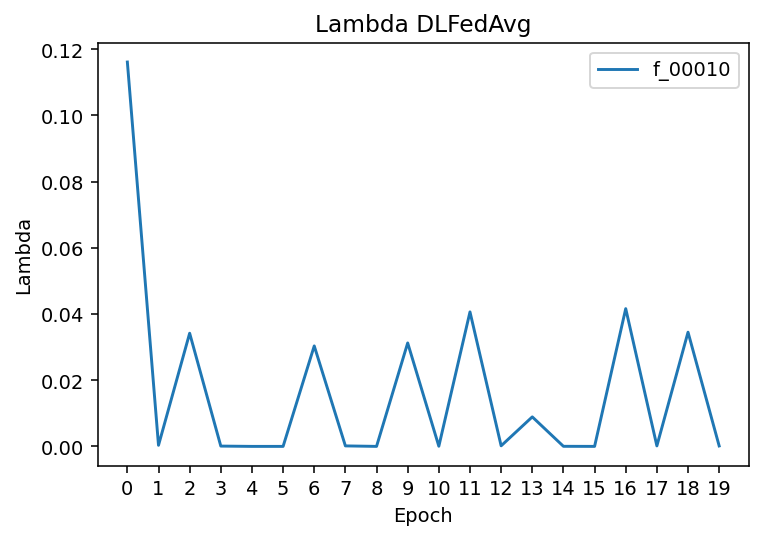

In [11]:
c_name = 'f_00010'
ld_list_10 = []
x = range(20)
for ld in ld_hist:
    ld_list_10.append(ld[c_name])
plt.title('Lambda DLFedAvg')
plt.xlabel('Epoch')
plt.ylabel('Lambda')
plt.xticks(x)
plt.plot(x, ld_list_10, label=c_name)
plt.legend()
plt.savefig(c_name+'_lambda.png')

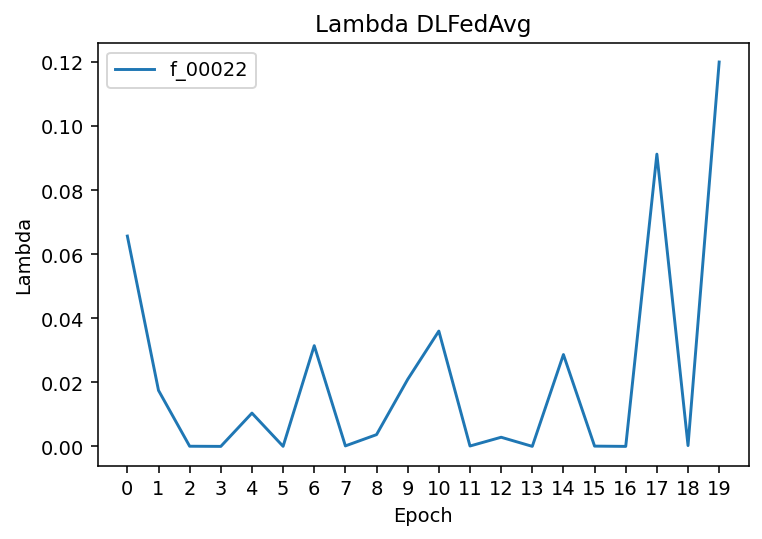

In [12]:
c_name = 'f_00022'
ld_list_22 = []
x = range(20)
for ld in ld_hist:
    ld_list_22.append(ld[c_name])
plt.title('Lambda DLFedAvg')
plt.xlabel('Epoch')
plt.ylabel('Lambda')
plt.xticks(x)
plt.plot(x, ld_list_22, label=c_name)
plt.legend()
plt.savefig(c_name+'_lambda.png')

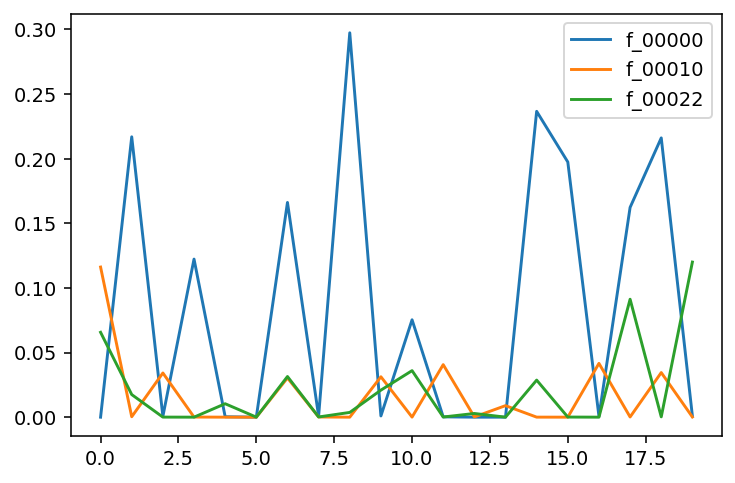

In [32]:
plt.plot(ld_list_00, label='f_00000')
plt.plot(ld_list_10, label='f_00010')
plt.plot(ld_list_22, label='f_00022')
plt.legend()

In [14]:
# Acc hist by epoch

In [15]:
acc_hist = server.metrics.metrics['acc']

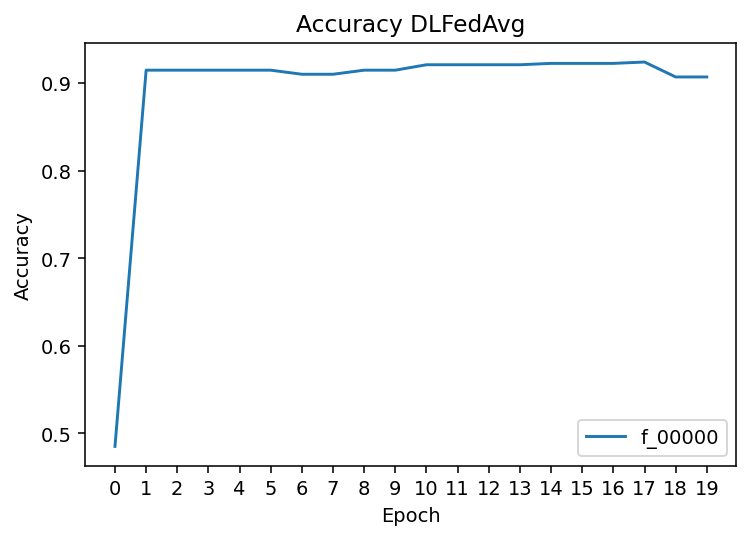

In [17]:
c_name = 'f_00000'
acc_list_00 = []
x = range(20)
for acc in acc_hist:
    acc_list_00.append(acc[c_name])
plt.title('Accuracy DLFedAvg')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(x)
plt.plot(x, acc_list_00, label=c_name)
plt.legend()
plt.savefig(c_name+'_acc.png')

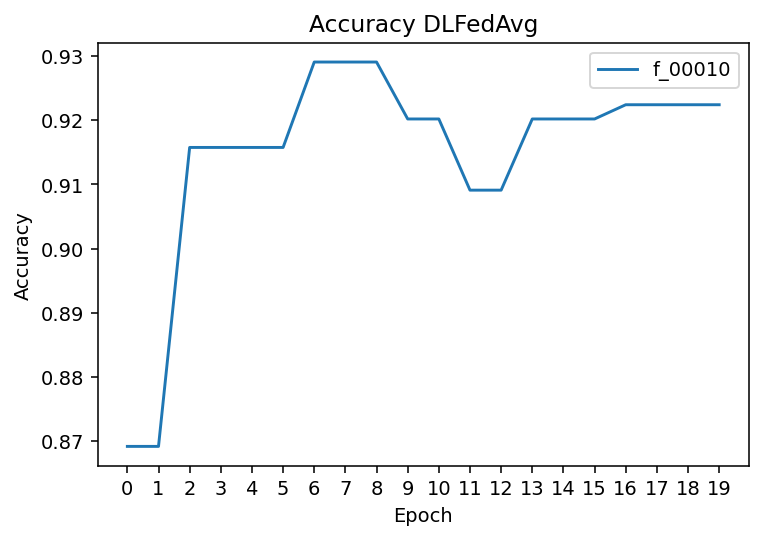

In [24]:
c_name = 'f_00010'
acc_list_10 = []
x = range(20)
for acc in acc_hist:
    acc_list_10.append(acc[c_name])
plt.title('Accuracy DLFedAvg')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(x)
plt.plot(x, acc_list_10, label=c_name)
plt.legend()
plt.savefig(c_name+'_acc.png')

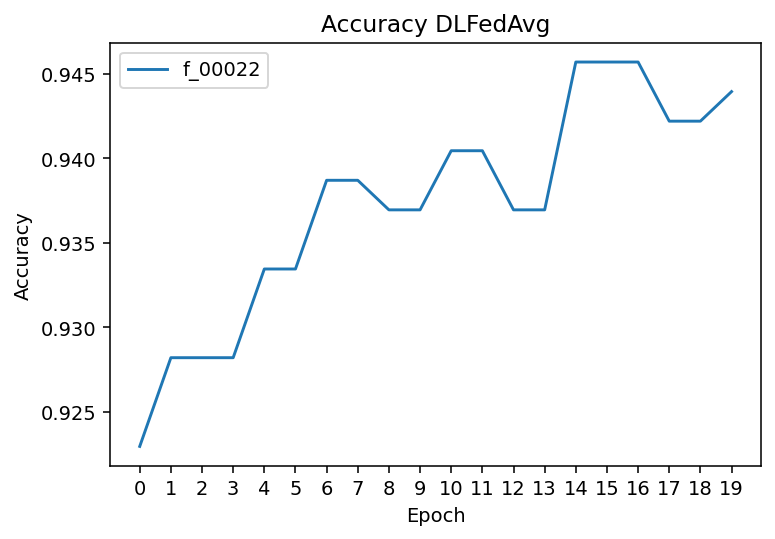

In [25]:
c_name = 'f_00022'
acc_list_22 = []
x = range(20)
for acc in acc_hist:
    acc_list_22.append(acc[c_name])
plt.title('Accuracy DLFedAvg')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(x)
plt.plot(x, acc_list_22, label=c_name)
plt.legend()
plt.savefig(c_name+'_acc.png')

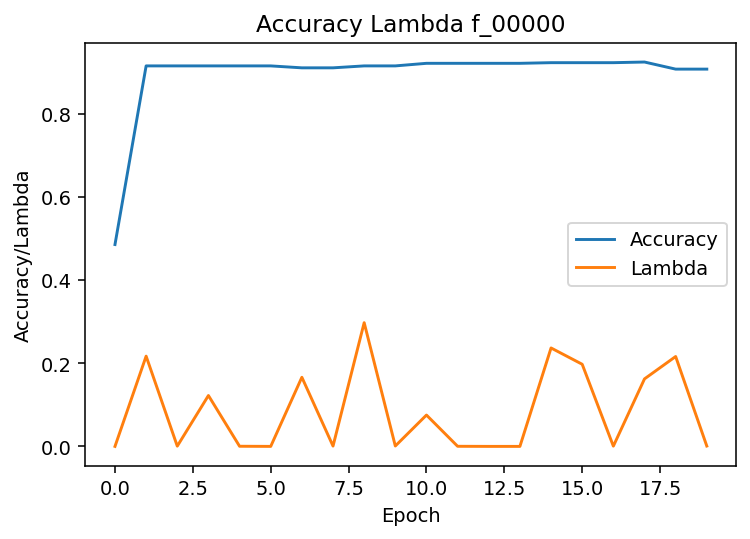

In [23]:
plt.title('Accuracy Lambda f_00000')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Lambda')

plt.plot(acc_list_00, label='Accuracy')
plt.plot(ld_list_00, label='Lambda')
plt.legend()

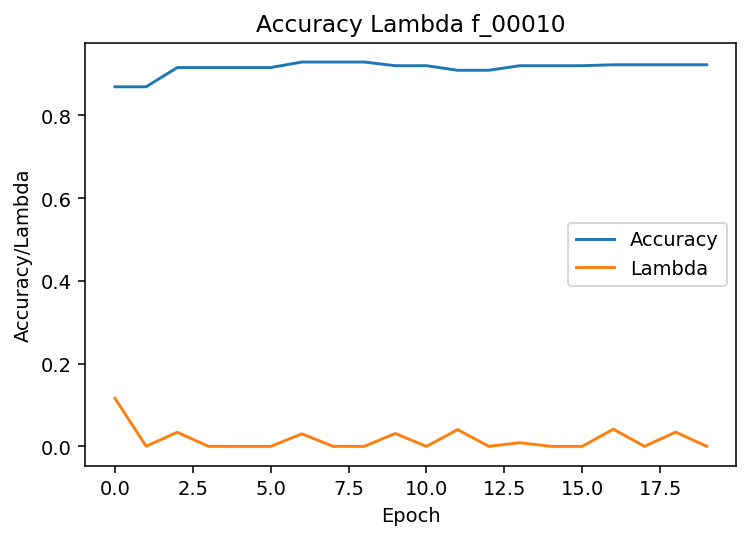

In [26]:
plt.title('Accuracy Lambda f_00010')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Lambda')

plt.plot(acc_list_10, label='Accuracy')
plt.plot(ld_list_10, label='Lambda')
plt.legend()

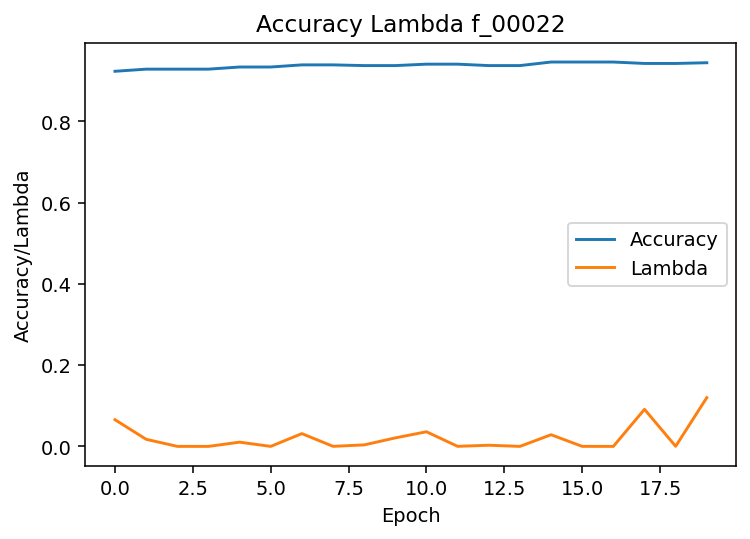

In [27]:
plt.title('Accuracy Lambda f_00022')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Lambda')

plt.plot(acc_list_22, label='Accuracy')
plt.plot(ld_list_22, label='Lambda')
plt.legend()

In [52]:
var_list = []
for acc in acc_hist:
    acc_list.append(np.var(list(acc.values())))

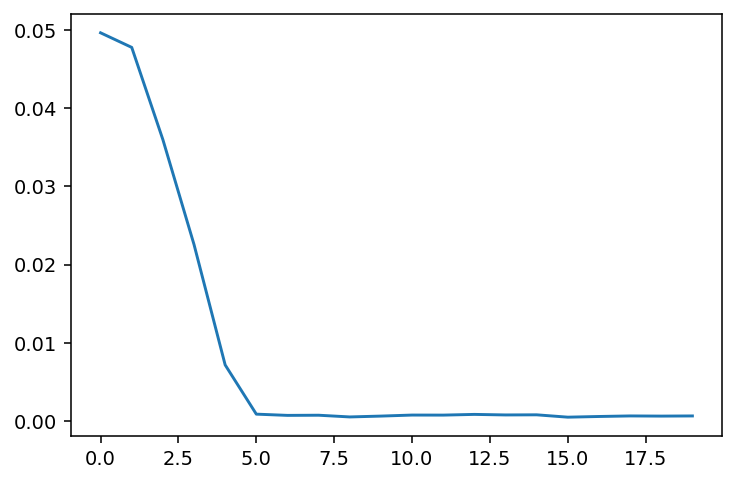

In [64]:
plt.plot(acc_list)

Text(0.5, 1.0, 'Lambda distribution')

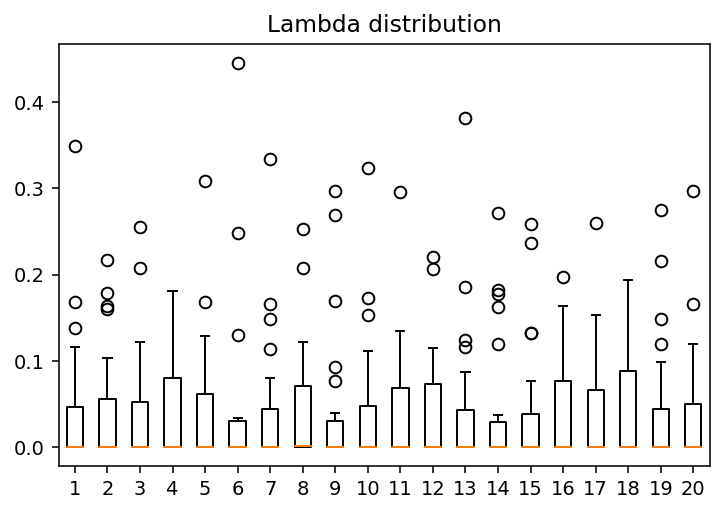

In [63]:
ld_list = []
for ld in ld_hist:
    ld_list.append(list(ld.values()))
plt.boxplot(ld_list)
plt.title('Lambda distribution')

In [53]:
acc_list

[0.04959442185000249,
 0.04773112245849978,
 0.03595677763479648,
 0.02255849284862781,
 0.007182187934705582,
 0.0008982340617247848,
 0.0007407447511739793,
 0.0007605866925757246,
 0.0005418957831297781,
 0.0006504187649910877,
 0.0007816876031303671,
 0.0007755746404039278,
 0.000866101448718305,
 0.0007964787970319938,
 0.0008125533917458116,
 0.0005121716187083301,
 0.0005995599993342935,
 0.0006697952083799271,
 0.0006483743720900136,
 0.0006688778555750135]